<a href="https://colab.research.google.com/github/Yan-Santana/CNN_para_d-gitos_manuscritos/blob/main/C%C3%B3pia_de_CNN_para_d%C3%ADgitos_manuscritos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importe as bibliotecas

In [ ]:

import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# ...

# Dataset

Baixar o dataset

In [ ]:
# Baixar o dataset
from torchvision import datasets
from torchvision import transforms

# Se o download falhar, tente novamente
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./datasets", train=False, download=True, transform=transforms.ToTensor())


In [ ]:
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

Visualizar o dataset

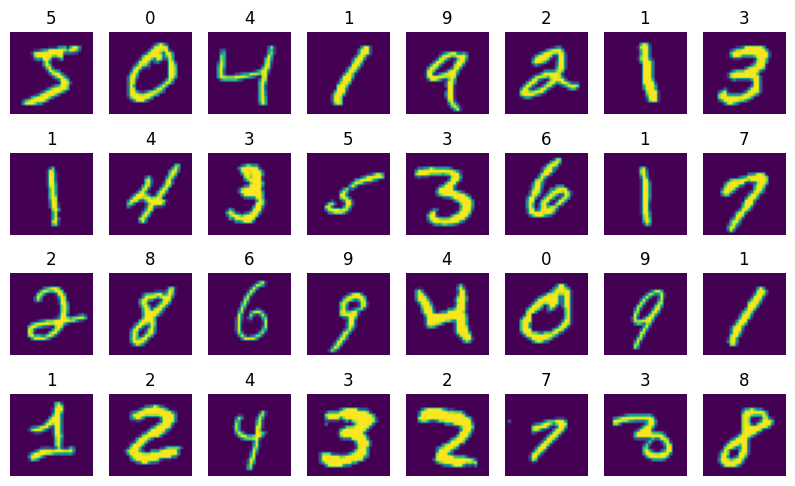

In [ ]:
ROWS, COLS = 4, 8

fig, axs = plt.subplots(ROWS, COLS, figsize=(10, 6))
for i, ax in enumerate(axs.flatten()):
    img, label = train_val_dataset[i]
    ax.imshow(img.numpy()[0])
    ax.set_title(label)
    ax.axis('off')

# Construa uma arquitetura de rede convolucional


## LeNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir transformações para os dados
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Data augmentation
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Definir tamanhos de treino e validação
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

# Dividir o dataset em treino e validação
train_dataset, val_dataset = data.random_split(train_val_dataset, [train_size, val_size])

# Criar DataLoader para treino e validação com batch size maior
batch_size = 256  # Ajuste o tamanho do lote conforme necessário
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Função para converter DataLoader do PyTorch para arrays do Numpy
def dataloader_to_numpy(dataloader):
    images, labels = [], []
    for batch in dataloader:
        imgs, lbls = batch
        images.append(imgs.numpy())
        labels.append(lbls.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# Converter dados de treino, validação e teste
x_train, y_train = dataloader_to_numpy(train_loader)
x_val, y_val = dataloader_to_numpy(val_loader)
x_test, y_test = dataloader_to_numpy(test_loader)

# Redimensionar e normalizar os dados
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# One-hot encoding dos rótulos
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Construir o modelo LeNet
model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilar o modelo
optimizer = Adam(learning_rate=0.001)  # Taxa de aprendizado ajustada para LeNet
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacks para early stopping e redução da taxa de aprendizado
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Treinar o modelo
epochs = 10  # Número de épocas
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=callbacks)

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
1500/1500 [==============================] - 27s 17ms/step - loss: 0.2135 - accuracy: 0.9350 - val_loss: 0.1050 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/10
1500/1500 [==============================] - 28s 18ms/step - loss: 0.0704 - accuracy: 0.9781 - val_loss: 0.0567 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 3/10
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0508 - accuracy: 0.9834 - val_loss: 0.0523 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 4/10
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0400 - accuracy: 0.9877 - val_loss: 0.0536 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 5/10
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0311 - accuracy: 0.9904 - val_loss: 0.0461 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 6/10
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.0513 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 7/10
1500/1500 [========================

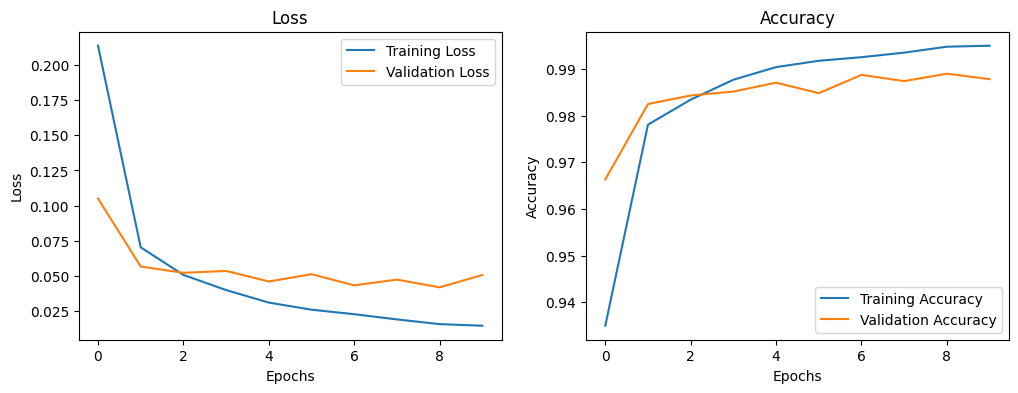

In [ ]:
# Plotar a perda
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotar a acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

313/313 [==============================] - 2s 6ms/step


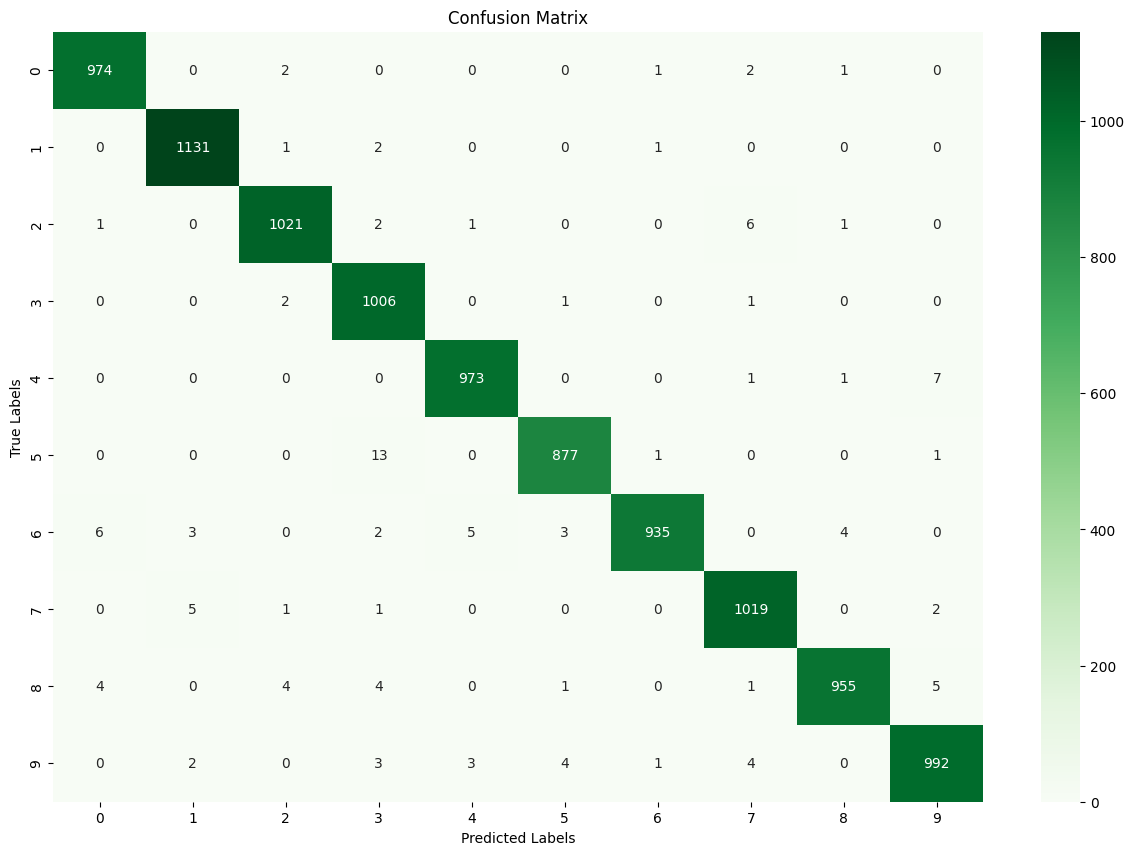

In [ ]:
# Fazer previsões no conjunto de teste
predictions = model.predict(x_test)
predict_classes = np.argmax(predictions, axis=1)

# Calcular matriz de confusão
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predict_classes)

# Plotar a matriz de confusão
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap="Greens")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

# LeNet

## Análise dos Gráficos de Perda e Acurácia e da Matriz de Confusão
<br><br>
Desempenho Geral do Modelo LeNet:

    Perda de Teste (loss): 0.0422
    Acurácia de Teste: 98.83%
<br>
Interpretação dos Gráficos e Dados:
Gráfico de Perda:

    Perda de Treinamento:
        A perda de treinamento começa em torno de 0.2 e diminui consistentemente à medida que o treinamento progride.
        Há uma redução significativa na perda nas primeiras épocas, indicando que o modelo está aprendendo rapidamente durante esse período inicial.
        A perda continua a diminuir, mas a taxa de redução desacelera nas últimas épocas, estabilizando em torno de 0.015 na última época.

    Perda de Validação:
        A perda de validação começa em um valor mais alto em comparação com a perda de treinamento inicial e diminui à medida que o treinamento continua.
        A perda de validação segue um padrão de diminuição similar ao da perda de treinamento, indicando que o modelo está generalizando bem e aprendendo de maneira eficaz a partir dos dados de validação.
        A perda de validação é consistentemente mais baixa que a perda de treinamento, sugerindo que o modelo não está superajustando (overfitting).
<br>
Gráfico de Acurácia:

    Acurácia de Treinamento:
        A acurácia de treinamento começa em torno de 93.50% e aumenta rapidamente nas primeiras épocas.
        A taxa de aumento da acurácia desacelera, mas continua a melhorar até atingir cerca de 99.50% na última época.
        Isso mostra que o modelo está aprendendo a identificar corretamente as classes dos dados de treinamento.

    Acurácia de Validação:
        A acurácia de validação começa em um valor alto (96.63%) e melhora ao longo das épocas, atingindo 98.78% na última época.
        A acurácia de validação é consistentemente mais alta que a acurácia de treinamento, indicando que o modelo está generalizando bem e não está superajustando.
        A melhoria na acurácia de validação acompanha a melhoria na acurácia de treinamento, o que é um sinal positivo.
<br>
Matriz de Confusão:

A matriz de confusão mostra o desempenho do modelo em classificar corretamente cada uma das classes do conjunto de teste.

Observações importantes:

    A diagonal principal da matriz contém os valores mais altos, indicando que a maioria das previsões do modelo está correta.
    Os valores fora da diagonal principal são baixos, indicando que o modelo está cometendo poucos erros de classificação.
    As confusões mais comuns (valores mais altos fora da diagonal) podem ser analisadas para entender onde o modelo pode estar cometendo erros específicos.
<br>
Conclusões Finais:

    Bom Desempenho Geral:
        O modelo está apresentando um excelente desempenho com uma acurácia de validação e teste muito alta, atingindo 98.83% no conjunto de teste.

    Generalização Eficiente:
        A perda de validação mais baixa e a acurácia de validação mais alta em comparação com os dados de treinamento sugerem que o modelo está generalizando bem e não está superajustando.

    Aprendizado Rápido:
        O modelo aprende rapidamente nas primeiras épocas, como mostrado pela rápida redução na perda de treinamento e aumento na acurácia de treinamento.

    Sem Overfitting Aparente:
        A perda de validação mais baixa e a acurácia de validação mais alta em comparação com os dados de treinamento sugerem que o modelo não está superajustando os dados de treinamento.
<br>
Justificativa dos Resultados:

  Os resultados indicam que o modelo LeNet é altamente eficaz para a tarefa de classificação de dígitos manuscritos no dataset MNIST. A alta acurácia e a baixa perda tanto nos conjuntos de validação quanto de teste sugerem que o modelo está aprendendo bem os padrões dos dados sem memorizar os exemplos específicos de treinamento (sem overfitting). A matriz de confusão confirma que o modelo está classificando corretamente a maioria dos dígitos, com poucas confusões, indicando uma boa capacidade de generalização.



---



## AlexNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



# Definir tamanhos de treino e validação
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

# Dividir o dataset em treino e validação
train_dataset, val_dataset = data.random_split(train_val_dataset, [train_size, val_size])

# Criar DataLoader para treino e validação com batch size maior
batch_size = 256
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Função para converter DataLoader do PyTorch para arrays do Numpy
def dataloader_to_numpy(dataloader):
    images, labels = [], []
    for batch in dataloader:
        imgs, lbls = batch
        images.append(imgs.numpy())
        labels.append(lbls.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# Converter dados de treino, validação e teste
x_train, y_train = dataloader_to_numpy(train_loader)
x_val, y_val = dataloader_to_numpy(val_loader)
x_test, y_test = dataloader_to_numpy(test_loader)

# Redimensionar e normalizar os dados
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_val = x_val.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# One-hot encoding dos rótulos
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Construir o modelo CNN inspirado no AlexNet, ajustado para MNIST
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation='softmax'),
])

# Compilar o modelo
optimizer = Adam(learning_rate=0.0001)  # Redução na taxa de aprendizado
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Callbacks para early stopping e redução da taxa de aprendizado
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Treinar o modelo
epochs = 10  # Aumentar o número de épocas
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=callbacks)

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
1500/1500 [==============================] - 126s 83ms/step - loss: 0.6169 - accuracy: 0.8097 - val_loss: 0.1084 - val_accuracy: 0.9677 - lr: 1.0000e-04
Epoch 2/10
1500/1500 [==============================] - 124s 83ms/step - loss: 0.1842 - accuracy: 0.9464 - val_loss: 0.0631 - val_accuracy: 0.9807 - lr: 1.0000e-04
Epoch 3/10
1500/1500 [==============================] - 126s 84ms/step - loss: 0.1238 - accuracy: 0.9636 - val_loss: 0.0490 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 4/10
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0955 - accuracy: 0.9726 - val_loss: 0.0405 - val_accuracy: 0.9873 - lr: 1.0000e-04
Epoch 5/10
1500/1500 [==============================] - 143s 95ms/step - loss: 0.0770 - accuracy: 0.9772 - val_loss: 0.0411 - val_accuracy: 0.9857 - lr: 1.0000e-04
Epoch 6/10
1500/1500 [==============================] - 161s 107ms/step - loss: 0.0638 - accuracy: 0.9812 - val_loss: 0.0308 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 7/10
1500

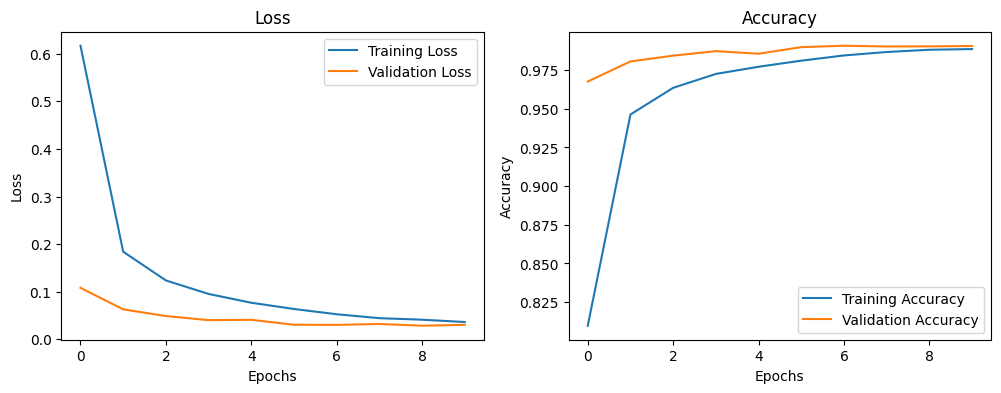

In [ ]:
# Plotar a perda
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotar a acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


313/313 [==============================] - 6s 19ms/step


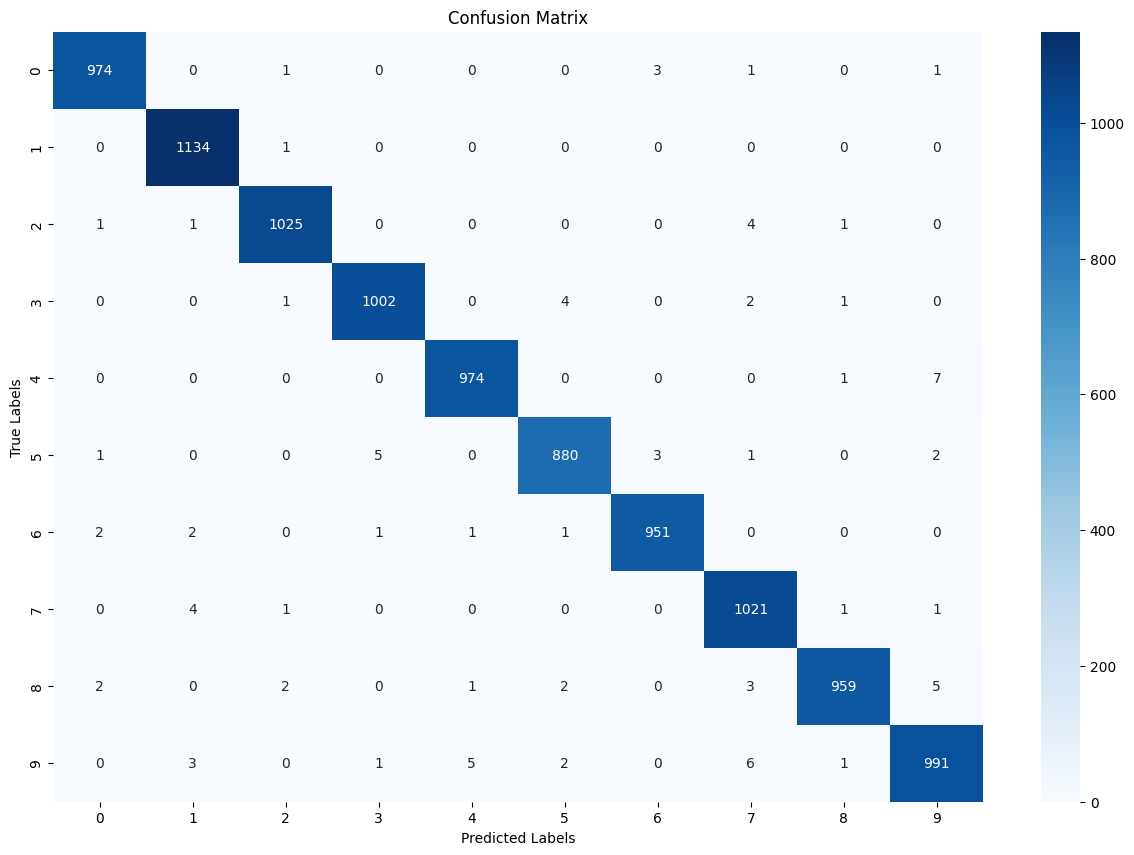

In [ ]:
# Fazer previsões no conjunto de teste
predictions = model.predict(x_test)
predict_classes = np.argmax(predictions, axis=1)

# Calcular matriz de confusão
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predict_classes)

# Plotar a matriz de confusão
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

# AlexNet

Análise dos Gráficos de Perda e Acurácia e da Matriz de Confusão
Desempenho Geral do Modelo AlexNet:

    Perda de Teste (loss): 0.0273
    Acurácia de Teste: 99.11%

Interpretação dos Gráficos e Dados:
Gráfico de Perda:

    Perda de Treinamento:
        A perda de treinamento começa em torno de 0.6 e diminui de forma consistente à medida que o treinamento progride.
        Há uma redução significativa na perda nas primeiras épocas, indicando que o modelo está aprendendo rapidamente durante esse período inicial.
        A perda continua a diminuir, estabilizando em torno de 0.036 na última época.

    Perda de Validação:
        A perda de validação começa em um valor mais alto em comparação com a perda de treinamento inicial e diminui à medida que o treinamento continua.
        A perda de validação segue um padrão de diminuição similar ao da perda de treinamento, indicando que o modelo está generalizando bem e aprendendo de maneira eficaz a partir dos dados de validação.
        A perda de validação é consistentemente mais baixa que a perda de treinamento, sugerindo que o modelo não está superajustando (overfitting).

Gráfico de Acurácia:

    Acurácia de Treinamento:
        A acurácia de treinamento começa em torno de 80.97% e aumenta rapidamente nas primeiras épocas.
        A taxa de aumento da acurácia desacelera, mas continua a melhorar até atingir cerca de 98.87% na última época.
        Isso mostra que o modelo está aprendendo a identificar corretamente as classes dos dados de treinamento.

    Acurácia de Validação:
        A acurácia de validação começa em um valor alto (96.77%) e melhora ao longo das épocas, atingindo 99.07% na última época.
        A acurácia de validação é consistentemente mais alta que a acurácia de treinamento, indicando que o modelo está generalizando bem e não está superajustando.
        A melhoria na acurácia de validação acompanha a melhoria na acurácia de treinamento, o que é um sinal positivo.

Matriz de Confusão:

A matriz de confusão mostra o desempenho do modelo em classificar corretamente cada uma das classes do conjunto de teste.

Observações importantes:

    A diagonal principal da matriz contém os valores mais altos, indicando que a maioria das previsões do modelo está correta.
    Os valores fora da diagonal principal são baixos, indicando que o modelo está cometendo poucos erros de classificação.
    As confusões mais comuns (valores mais altos fora da diagonal) podem ser analisadas para entender onde o modelo pode estar cometendo erros específicos.

Conclusões Finais:

    Bom Desempenho Geral:
        O modelo está apresentando um excelente desempenho com uma acurácia de validação e teste muito alta, atingindo 99.11% no conjunto de teste.

    Generalização Eficiente:
        A perda de validação mais baixa e a acurácia de validação mais alta em comparação com os dados de treinamento sugerem que o modelo está generalizando bem e não está superajustando.

    Aprendizado Rápido:
        O modelo aprende rapidamente nas primeiras épocas, como mostrado pela rápida redução na perda de treinamento e aumento na acurácia de treinamento.

    Sem Overfitting Aparente:
        A perda de validação mais baixa e a acurácia de validação mais alta em comparação com os dados de treinamento sugerem que o modelo não está superajustando os dados de treinamento.

Justificativa dos Resultados:

Os resultados indicam que o modelo AlexNet é altamente eficaz para a tarefa de classificação de dígitos manuscritos no dataset MNIST. A alta acurácia e a baixa perda tanto nos conjuntos de validação quanto de teste sugerem que o modelo está aprendendo bem os padrões dos dados sem memorizar os exemplos específicos de treinamento (sem overfitting). A matriz de confusão confirma que o modelo está classificando corretamente a maioria dos dígitos, com poucas confusões, indicando uma boa capacidade de generalização.



---



---



#  Comparativa dos Modelos LeNet e AlexNet

Ao comparar os resultados do modelo AlexNet com o modelo LeNet, observa-se que ambos os modelos apresentam um desempenho excepcional com leves diferenças. AlexNet tem uma acurácia de teste ligeiramente superior (99.11% vs. 98.83%) e uma perda de teste menor (0.0273 vs. 0.0422). Essas diferenças, embora pequenas, indicam que AlexNet pode ter uma ligeira vantagem em termos de precisão. No entanto, ambos os modelos são altamente eficazes para a classificação de dígitos manuscritos e podem ser considerados dependendo das necessidades específicas de desempenho e recursos computacionais.

# Conclusão

Esses resultados ressaltam a eficácia duradoura dessas redes neurais convolucionais clássicas para tarefas de classificação de imagens, mesmo com os avanços recentes em arquiteturas mais complexas. Ambos os modelos, LeNet e AlexNet, demonstraram ser capazes de lidar com eficiência com o desafio de reconhecimento de dígitos manuscritos do MNIST.

Apesar da simplicidade relativa da LeNet, ela oferece um desempenho robusto que é quase comparável ao da AlexNet. A AlexNet, por sua vez, oferece uma ligeira vantagem em termos de acurácia, tornando-se uma escolha preferida quando o desempenho é crítico e os recursos computacionais não são uma limitação.

Em resumo, a escolha entre LeNet e AlexNet pode depender de fatores como disponibilidade de recursos computacionais, tempo de treinamento e requisitos de implementação. No entanto, ambas as arquiteturas são altamente recomendáveis em termos de desempenho para a tarefa de classificação de dígitos manuscritos do MNIST.